<a href="https://colab.research.google.com/github/ilmondovero/sf/blob/main/Lazy%20Portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


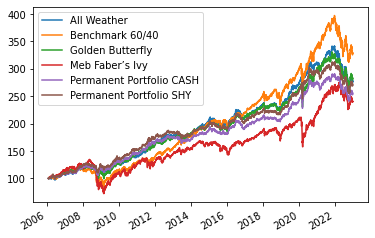

In [3]:
!pip install tiingo
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 28 16:45:57 2019
http://www.lazyportfolioetf.com/portfolio-basic-components/
@author: ilmondovero
"""
from tiingo import TiingoClient
import pandas as pd
from datetime import datetime

def rebalace_annually(universe,capital,df_rend):
    df_rend=df_rend[list(universe.keys())]#select the portfolio ticker
    data={}#create a dict to store every year
    for year in sorted(set(df_rend.index.year)):#set is not sorted
        data[year]=((1+df_rend[df_rend.index.year==year]).cumprod()-1)*capital+capital#make a productory
        data[year]*= data[year].columns.map(universe)/100#multyply for weights
        capital=data[year].iloc[-1].sum()#update capital
    df_strategy=pd.concat(data.values())#rebuild the equity
    return df_strategy.sum(axis=1)#create a portfolio

config = {}
config['session'] = True
config['api_key'] = "fbb82277db40c7a1924d0a5bcf1d563bd21323cd"
client = TiingoClient(config)
capital = 100000
strategy={}
strategy["All Weather"]={"DBC":7.5,"GLD":7.5,"IEF":15,"SPY":30,"TLT":40}
strategy["Benchmark 60/40"]={"SPY":60,"IEF":40}
#strategy["Benchmark 100 SPY"]={"SPY":100}
strategy["Golden Butterfly"]={"GLD":20,"IWN":20,"SHY":20,"SPY":20,"TLT":20}
strategy["Meb Faber’s Ivy"]={"DBC":20,"EFA":20,"IEF":20,"SPY":20,"VNQ":20}
strategy["Permanent Portfolio CASH"]={"GLD":25,"SPY":25,"TLT":25,"CASH":25}
strategy["Permanent Portfolio SHY"]={"GLD":25,"SPY":25,"TLT":25,"SHY":25}
ticker=set().union(*(d.keys() for d in strategy.values()))#extract the ticker and remove the duplicates

oggi=datetime.today().strftime('%Y-%m-%d')
try:
    data=pd.read_pickle(oggi+'_database.pkl')
except:
    print('connessione')
    if "CASH" in ticker:
        ticker.remove("CASH")
        data=client.get_dataframe(ticker,frequency='daily',metric_name='adjClose',startDate='2000-01-01').dropna()#download data
        data["CASH"]=100
    else:
        data=client.get_dataframe(ticker,frequency='daily',metric_name='adjClose',startDate='2000-01-01').dropna()#download data
    data.to_pickle(oggi+'_database.pkl')

df_rend=data.pct_change().dropna()#calc returns
df_rend.index = pd.to_datetime(df_rend.index)#convert index from string to datetime
equity = {k: rebalace_annually(v,capital,df_rend) for k, v in strategy.items()}#calc the strategy
df=pd.concat(equity,axis=1).dropna()#create a dataframe comparable
df=df/df.iloc[0]*100#normalize dataframe
df.plot()#.legend(bbox_to_anchor=(1.04,1), loc="upper left")